## Ventilation Pressure Prediction

### Introduction

kaggle: https://www.kaggle.com/c/ventilator-pressure-prediction/overview

In this competition, you’ll simulate a ventilator connected to a sedated patient's lung. The best submissions will take lung attributes **compliance and resistance** into account.

**Compliance**: Compliance is volume divided by change in pressure

**Resistance**: Resistance is the change in pressure divided by flow

### Evaluation

The competition will be scored as the mean absolute error between the predicted and actual pressures during the inspiratory phase of each breath. The expiratory phase is not scored. The score is given by:

                |𝑋−𝑌|
                
where 𝑋 is the vector of predicted pressure and 𝑌 is the vector of actual pressures across all breaths in the test set.

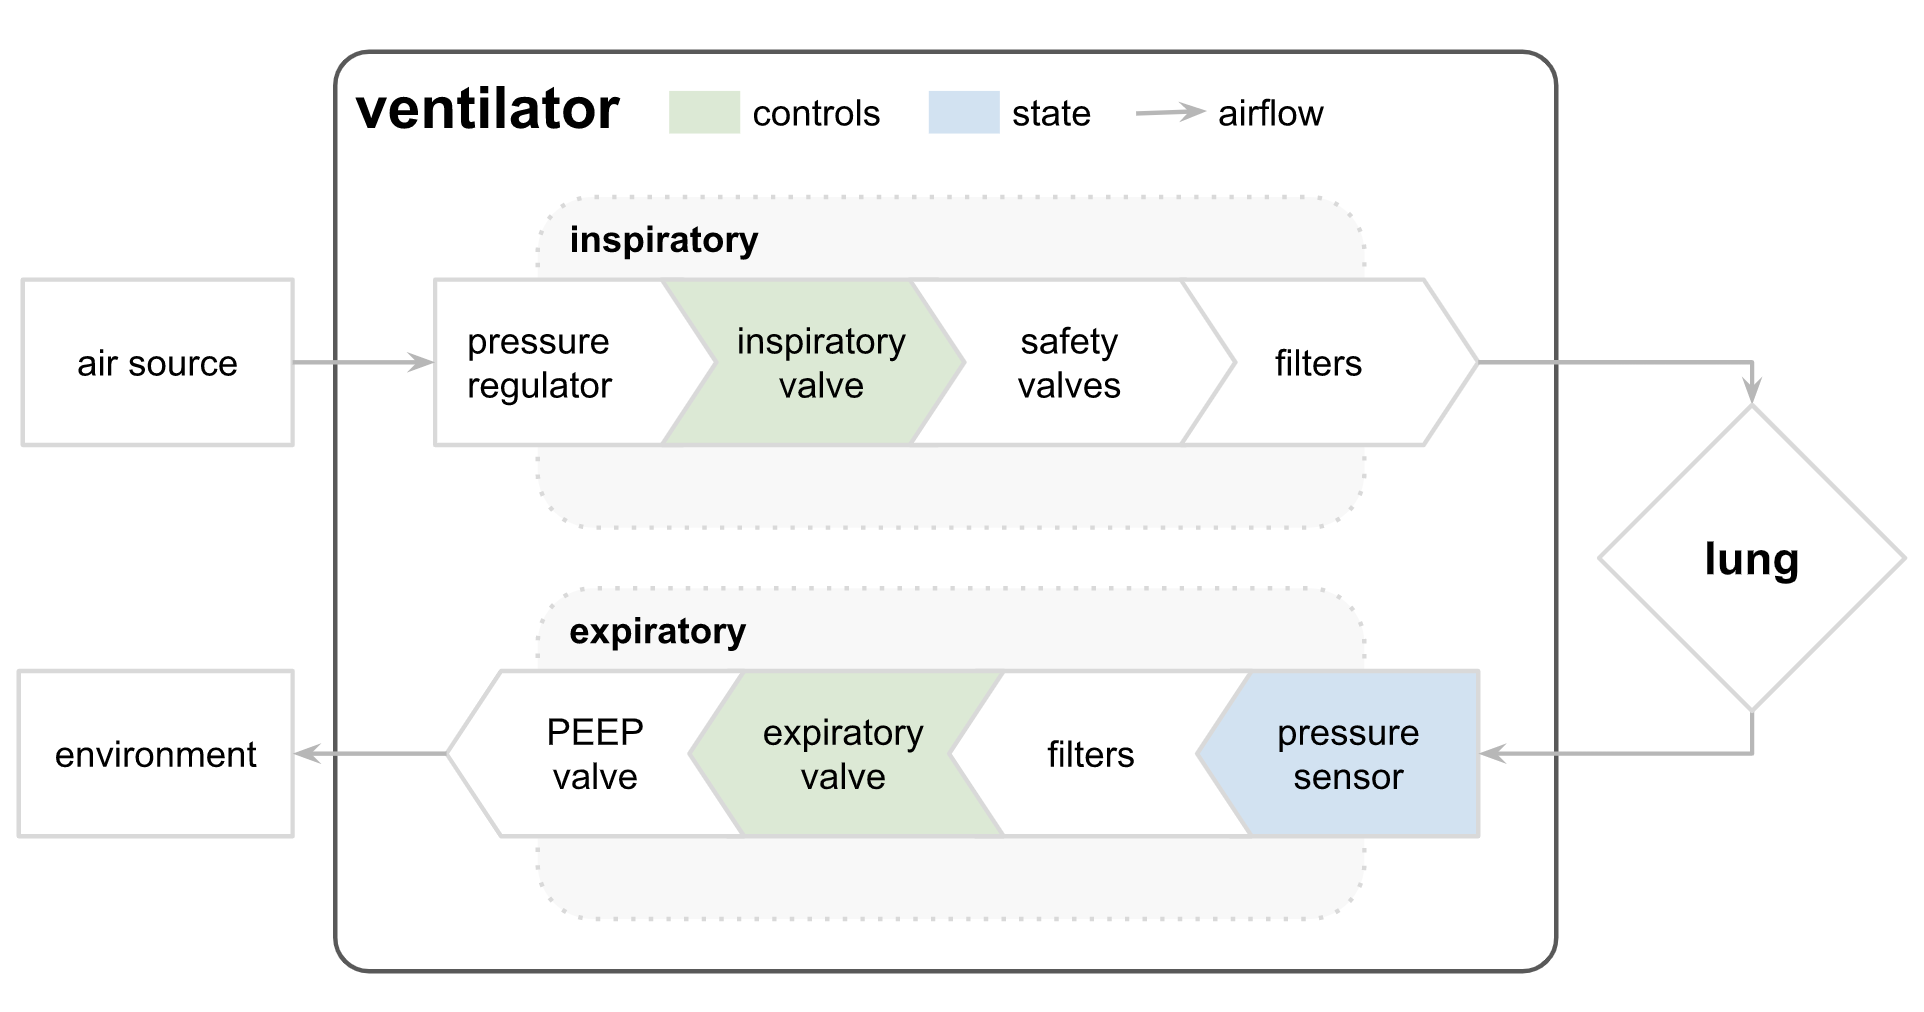


### Variables Description

   - **id** - globally-unique time step identifier across an entire file
    
   - **breath_id** - globally-unique time step for breaths
   - **R** - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
   - **C** - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
   - **time_step** - the actual time stamp.
   - **u_in(%)** - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.The first control input is a continuous variable from 0 to 100 representing the percentage the inspiratory solenoid valve is open to let air into the lung (i.e., 0 is completely closed and no air is let in and 100 is completely open).
   - **u_out** - the control input for the exploratory solenoid valve. Either 0 or 1. The second control input is a binary variable representing whether the exploratory valve is open (1) or closed (0) to let air out.
   - **pressure** - the airway pressure measured in the respiratory circuit, measured in cmH2O.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import plotly.graph_objects as go


%matplotlib inline

In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dropout



Using TensorFlow backend.


## Read data

In [54]:
train = pd.read_csv('../data/ventilator-pressure-prediction/train.csv')
print('Train shape: ', train.shape)
test = pd.read_csv('../data/ventilator-pressure-prediction/test.csv')
print('Test shape: ', test.shape)
submisison = pd.read_csv('../data/ventilator-pressure-prediction/sample_submission.csv')

Train shape:  (6036000, 8)
Test shape:  (4024000, 7)


In [106]:
test = pd.read_csv('../data/ventilator-pressure-prediction/test.csv')


In [55]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [56]:
test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [57]:
train.dtypes

id             int64
breath_id      int64
R              int64
C              int64
time_step    float64
u_in         float64
u_out          int64
pressure     float64
dtype: object

In [58]:
test['breath_id'].value_counts()

0         80
21851     80
107877    80
114022    80
111975    80
          ..
113296    80
105108    80
103061    80
119453    80
8188      80
Name: breath_id, Length: 50300, dtype: int64

## EDA

In [59]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [60]:
eda_columns = ['breath_id','R','C','time_step', 'u_in','u_out','pressure']

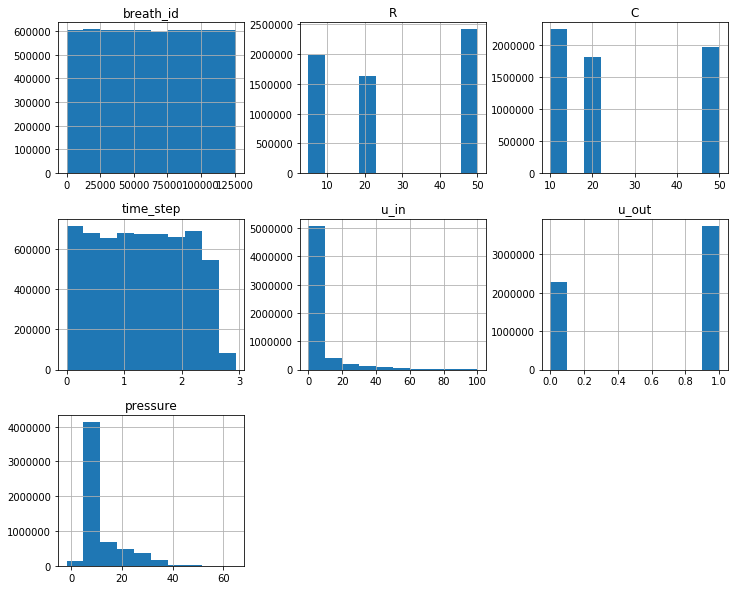

In [61]:
train[eda_columns].hist(figsize = (12,10))
plt.show()

In [62]:
# Create traces
fig = go.Figure()
for id_ in list(set(train['breath_id']))[:10]:
    fig.add_trace(go.Scatter(x=train[train['breath_id']==id_]['time_step'], y=train[train['breath_id']==id_]['pressure'],
                        mode='lines',
                        name=str(id_)))
    
fig.update_layout(title='Pressure v/s Timestamp',
                   xaxis_title='Timestamp',
                   yaxis_title='Pressure')

fig.show()

In [63]:
# Create traces
fig = go.Figure()
for id_ in list(set(train['breath_id']))[:10]:
    fig.add_trace(go.Scatter(x=train[train['breath_id']==id_]['time_step'], y=train[train['breath_id']==id_]['u_in'],
                        mode='lines',
                        name=str(id_)))
    
fig.update_layout(title='u_in v/s timestamp',
                   xaxis_title='Timestamp',
                   yaxis_title='u_in')

fig.show()

In [64]:
# Create traces
fig = go.Figure()
for id_ in list(set(train['breath_id']))[:10]:
    fig.add_trace(go.Scatter(x=train[train['breath_id']==id_]['time_step'], y=train[train['breath_id']==id_]['u_out'],
                        mode='lines',
                        name=str(id_)))
    
fig.update_layout(title='u_out v/s timestamp',
                   xaxis_title='Timestamp',
                   yaxis_title='u_out')

fig.show()

In [65]:
#sns.pairplot(train[eda_columns])

In [66]:
test['breath_id'].value_counts()

0         80
21851     80
107877    80
114022    80
111975    80
          ..
113296    80
105108    80
103061    80
119453    80
8188      80
Name: breath_id, Length: 50300, dtype: int64

In [67]:
## TODO: graph w.r.t pressure

In [68]:
corr_matrix = train[eda_columns].corr()

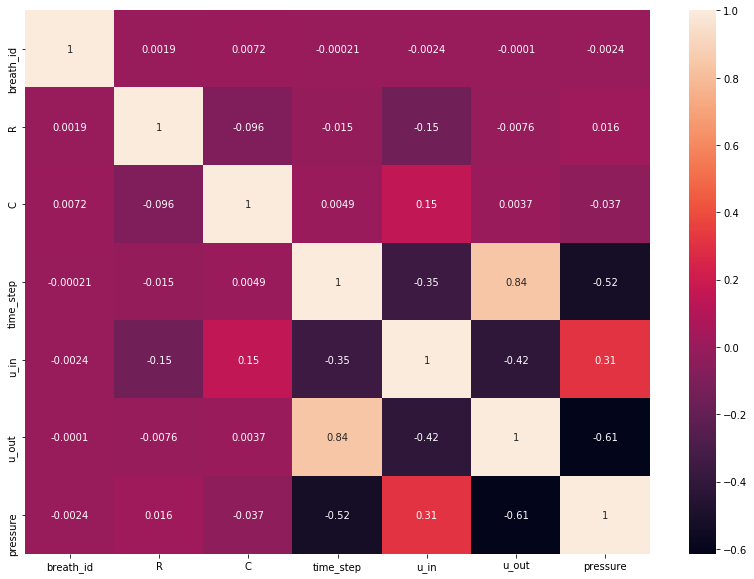

In [69]:
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=True)

In [70]:
train['breath_id']

0               1
1               1
2               1
3               1
4               1
            ...  
6035995    125749
6035996    125749
6035997    125749
6035998    125749
6035999    125749
Name: breath_id, Length: 6036000, dtype: int64

In [71]:
id_corr_matrix = train[train['breath_id']==1][eda_columns].corr()

In [72]:
train[train['breath_id']==1][eda_columns]

,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,20,50,0.000000,0.083334,0,5.837492
1,1,20,50,0.033652,18.383041,0,5.907794
2,1,20,50,0.067514,22.509278,0,7.876254
3,1,20,50,0.101542,22.808822,0,11.742872
4,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...
75,1,20,50,2.553593,4.974474,1,6.399909
76,1,20,50,2.587754,4.978481,1,6.610815
77,1,20,50,2.621773,4.981847,1,6.329607
78,1,20,50,2.655746,4.984683,1,6.540513


In [73]:
train[train['breath_id']==1][eda_columns]

,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,20,50,0.000000,0.083334,0,5.837492
1,1,20,50,0.033652,18.383041,0,5.907794
2,1,20,50,0.067514,22.509278,0,7.876254
3,1,20,50,0.101542,22.808822,0,11.742872
4,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...
75,1,20,50,2.553593,4.974474,1,6.399909
76,1,20,50,2.587754,4.978481,1,6.610815
77,1,20,50,2.621773,4.981847,1,6.329607
78,1,20,50,2.655746,4.984683,1,6.540513


## Preprocessing

### 1. Generate dummy variables

In [74]:
train['R'] = train['R'].astype("str")
train['C'] = train['C'].astype("str")

In [75]:
train = pd.get_dummies(train)

## Normalize input columns

In [110]:
def normlaize_input(df, inp_columns, add_columns=[]):
    X_values = df[inp_columns].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(X_values)
    normalize_df = pd.DataFrame(x_scaled, columns = inp_columns)
    normalize_df = normalize_df.set_index(df.index)
    for col in add_columns:
        normalize_df[col] = df[col]
    return normalize_df

In [71]:
inp_columns = ['R', 'C', 'time_step', 'u_in', 'u_out']
add_columns = ['pressure']
norm_df = normlaize_input(train, inp_columns, add_columns)

In [72]:
norm_df.head()

,breath_id,R,C,time_step,u_in,u_out,pressure
0,0.0,0.333333,1.0,0.000000,0.000833,0.0,5.837492
1,0.0,0.333333,1.0,0.011457,0.183830,0.0,5.907794
2,0.0,0.333333,1.0,0.022986,0.225093,0.0,7.876254
3,0.0,0.333333,1.0,0.034571,0.228088,0.0,11.742872
4,0.0,0.333333,1.0,0.046219,0.253559,0.0,12.234987


## Feature Engineering

In [76]:
train.tail()

,id,breath_id,time_step,u_in,u_out,pressure,R_20,R_5,R_50,C_10,C_20,C_50
6035995,6035996,125749,2.504603,1.489714,1,3.869032,0,0,1,1,0,0
6035996,6035997,125749,2.537961,1.488497,1,3.869032,0,0,1,1,0,0
6035997,6035998,125749,2.571408,1.558978,1,3.798729,0,0,1,1,0,0
6035998,6035999,125749,2.604744,1.272663,1,4.079938,0,0,1,1,0,0
6035999,6036000,125749,2.638017,1.482739,1,3.869032,0,0,1,1,0,0


In [77]:
train['u_in_lag1'] = train.groupby('breath_id')['u_in'].shift(1).fillna(0)
#train['pressure_lag1'] = train.groupby('breath_id')['pressure'].shift(1).fillna(0)
train['u_out_lag1'] = train.groupby('breath_id')['u_out'].shift(1).fillna(0)


In [78]:
train.head()

,id,breath_id,time_step,u_in,u_out,pressure,R_20,R_5,R_50,C_10,C_20,C_50,u_in_lag1,u_out_lag1
0,1,1,0.000000,0.083334,0,5.837492,1,0,0,0,0,1,0.000000,0.0
1,2,1,0.033652,18.383041,0,5.907794,1,0,0,0,0,1,0.083334,0.0
2,3,1,0.067514,22.509278,0,7.876254,1,0,0,0,0,1,18.383041,0.0
3,4,1,0.101542,22.808822,0,11.742872,1,0,0,0,0,1,22.509278,0.0
4,5,1,0.135756,25.355850,0,12.234987,1,0,0,0,0,1,22.808822,0.0


## Train test Split

In [79]:
train.columns

Index(['id', 'breath_id', 'time_step', 'u_in', 'u_out', 'pressure', 'R_20',
       'R_5', 'R_50', 'C_10', 'C_20', 'C_50', 'u_in_lag1', 'u_out_lag1'],
      dtype='object')

In [80]:
inp_col = ['time_step', 'u_in', 'u_out', 'R_20','R_5', 'R_50', 'C_10', 'C_20', 'C_50', 'u_in_lag1','u_out_lag1']
out_col = ['pressure']
x_train, x_test, y_train, y_test = train_test_split(train[inp_col], train[out_col])

In [81]:
x_train.shape

(4527000, 11)

In [82]:
x_test.shape

(1509000, 11)

## ML Models

### Linear Regression

In [83]:
#TODO: make ml model pipeline

In [84]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [85]:
linear_pred = linear_model.predict(x_test)

In [86]:
mean_absolute_error(y_test, linear_pred)

3.733833109613703

### Random Forest

In [133]:
%%time
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

/Users/nehapawar/Desktop/neha/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



CPU times: user 46min 43s, sys: 16.1 s, total: 46min 59s
Wall time: 47min


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [134]:
%%time
rf_pred = rf_model.predict(x_test)
mean_absolute_error(y_test, rf_pred)

CPU times: user 2min 23s, sys: 53.6 s, total: 3min 16s
Wall time: 3min 56s


1.456690338454862

In [80]:
%%time
rf_pred = rf_model.predict(x_test)
mean_absolute_error(y_test, rf_pred)

CPU times: user 2min 34s, sys: 56.1 s, total: 3min 30s
Wall time: 4min 8s


1.8680898877911551

In [21]:
%%time
rf_pred = rf_model.predict(x_test)
mean_absolute_error(y_test, rf_pred)

CPU times: user 2min 18s, sys: 52.1 s, total: 3min 10s
Wall time: 3min 47s


1.861944370073203

## XGBoost Regressor

In [121]:
x_train.dtypes

time_step     float64
u_in          float64
u_out           int64
R_20            uint8
R_5             uint8
R_50            uint8
C_10            uint8
C_20            uint8
C_50            uint8
u_in_lag1     float64
u_out_lag1    float64
dtype: object

In [122]:
%%time
xgb_model = XGBRegressor(objective ='reg:linear',n_estimators = 10,enable_categorical=True)
xgb_model.fit(x_train,y_train)

[19:06:32] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:06:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 4min 20s, sys: 3.62 s, total: 4min 24s
Wall time: 20.7 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [123]:
xgboost_pred = xgb_model.predict(x_test) 

In [124]:
mean_absolute_error(y_test, xgboost_pred)

2.048119264428748

In [177]:
mean_absolute_error(y_test, xgboost_pred)

2.2691741572348674

## NN

In [101]:
NN_model = Sequential()
# input layer
NN_model.add(Dense(128, kernel_initializer='normal', input_dim=x_train.shape[1], activation='relu'))
#hidden layer
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
#output layer
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

#compile the network
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 99,969
Trainable params: 99,969
Non-trainable params: 0
_________________________________________________________________


In [102]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [103]:
%%time
NN_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 3621600 samples, validate on 905400 samples
Epoch 1/50
3621600/3621600 [==============================] - 131s 36us/step - loss: 2.2102 - mean_absolute_error: 2.2102 - val_loss: 2.1109 - val_mean_absolute_error: 2.1109

Epoch 00001: val_loss improved from inf to 2.11089, saving model to Weights-001--2.11089.hdf5
Epoch 2/50
3621600/3621600 [==============================] - 126s 35us/step - loss: 2.1174 - mean_absolute_error: 2.1174 - val_loss: 2.1035 - val_mean_absolute_error: 2.1035

Epoch 00002: val_loss improved from 2.11089 to 2.10350, saving model to Weights-002--2.10350.hdf5
Epoch 3/50
3621600/3621600 [==============================] - 123s 34us/step - loss: 2.1004 - mean_absolute_error: 2.1004 - val_loss: 2.0904 - val_mean_absolute_error: 2.0904

Epoch 00003: val_loss improved from 2.10350 to 2.09037, saving model to Weights-003--2.09037.hdf5
Epoch 4/50
3621600/3621600 [==============================] - 122s 34us/step - loss: 2.0895 - mean_absolute_error: 2.0895 - val_l

In [104]:
nn_pred = NN_model.predict(x_test)

In [105]:
mean_absolute_error(y_test, nn_pred)

2.0392367959015907

In [ ]:
## Lightgbm

## LSTM

In [128]:
x_train.shape[1]

6

In [129]:
x_train.shape[-1]

6

In [140]:
x_train.head()

,breath_id,R,C,time_step,u_in,u_out
445046,0.073377,0.333333,1.0,0.069549,0.135289,0.0
5017312,0.831075,0.333333,0.0,0.367132,0.000000,1.0
2562226,0.423752,0.333333,0.0,0.757830,0.048684,1.0
5951139,0.985725,1.000000,0.0,0.204537,0.000000,0.0
5281030,0.874471,0.333333,0.0,0.765544,0.048835,1.0


In [143]:

from numpy import array
data = array([
	[0.1, 1.0],
	[0.2, 0.9],
	[0.3, 0.8],
	[0.4, 0.7],
	[0.5, 0.6],
	[0.6, 0.5],
	[0.7, 0.4],
	[0.8, 0.3],
	[0.9, 0.2],
	[1.0, 0.1]])

In [144]:
data.shape

(10, 2)

In [145]:
data = data.reshape(1, 10, 2)
print(data.shape)

(1, 10, 2)


In [146]:
x_train_reshape = np.reshape(1,x_train.shape[0], x_train.shape[1])
x_test_reshape = np.reshape(1,x_test.shape[0], x_test.shape[1])


TypeError: order must be str, not int

In [141]:
lstm_model = Sequential()
lstm_model.add(LSTM(64,return_sequences=True, input_shape=(x_train.shape[0], x_train.shape[1])))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(20,return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_absolute_error', optimizer='adam')
lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 4527000, 64)       18176     
_________________________________________________________________
dropout_5 (Dropout)          (None, 4527000, 64)       0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 20)                6800      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 24,997
Trainable params: 24,997
Non-trainable params: 0
_________________________________________________________________


In [142]:
lstm_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

ValueError: Error when checking input: expected lstm_8_input to have 3 dimensions, but got array with shape (4527000, 6)

## Output File

In [108]:
x_train.head()

,time_step,u_in,u_out,R_20,R_5,R_50,C_10,C_20,C_50,u_in_lag1,u_out_lag1
875215,0.518161,12.324282,0,0,0,1,0,1,0,7.179185,0.0
2378193,1.045437,0.000000,1,0,0,1,1,0,0,0.000000,1.0
5330592,1.089118,0.000000,1,0,1,0,0,0,1,0.000000,1.0
1859401,1.301043,0.000000,1,0,0,1,0,0,1,0.000000,1.0
5217249,1.687664,3.238010,1,0,1,0,0,0,1,2.908928,1.0


In [107]:
test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [109]:
test['R'] = test['R'].astype("str")
test['C'] = test['C'].astype("str")

In [110]:
test = pd.get_dummies(test)

In [111]:
test['u_in_lag1'] = test.groupby('breath_id')['u_in'].shift(1).fillna(0)
test['u_out_lag1'] = test.groupby('breath_id')['u_out'].shift(1).fillna(0)


In [112]:
test.head()

,id,breath_id,time_step,u_in,u_out,R_20,R_5,R_50,C_10,C_20,C_50,u_in_lag1,u_out_lag1
0,1,0,0.000000,0.000000,0,0,1,0,0,1,0,0.000000,0.0
1,2,0,0.031904,7.515046,0,0,1,0,0,1,0,0.000000,0.0
2,3,0,0.063827,14.651675,0,0,1,0,0,1,0,7.515046,0.0
3,4,0,0.095751,21.230610,0,0,1,0,0,1,0,14.651675,0.0
4,5,0,0.127644,26.320956,0,0,1,0,0,1,0,21.230610,0.0


In [113]:
test_inp_cols = list(test.columns)
test_inp_cols.remove('id')
test_inp_cols.remove('breath_id')


In [114]:
test_inp_cols

['time_step',
 'u_in',
 'u_out',
 'R_20',
 'R_5',
 'R_50',
 'C_10',
 'C_20',
 'C_50',
 'u_in_lag1',
 'u_out_lag1']

In [95]:
#test_norm = normlaize_input(test, test_inp_cols)

In [135]:
%%time
submit_pred = rf_model.predict(test[test_inp_cols])

CPU times: user 5min 42s, sys: 56.6 s, total: 6min 38s
Wall time: 7min 19s


In [136]:
submit_pred

array([6.31650739, 5.73133547, 6.67197817, ..., 5.81147991, 5.91623011,
       5.81710408])

In [137]:
list(submit_pred)

[6.316507393972972,
 5.731335465437791,
 6.67197817157506,
 7.254782957365644,
 9.043269537644584,
 9.510075783440671,
 11.006808460097048,
 13.076503622180853,
 14.765161155919065,
 15.355699177709287,
 16.522714792199476,
 17.51678712887967,
 18.018744447401357,
 19.581561140781886,
 20.69022597454755,
 21.667425796319456,
 21.59009343632312,
 21.970428043214206,
 23.271720755516213,
 24.283368628559227,
 24.953348074709293,
 26.857833194982753,
 27.744343249122593,
 28.236458267281083,
 27.965091985839386,
 23.424979432599866,
 19.441659871333954,
 11.640230790612513,
 19.21528696298106,
 22.165868007568605,
 26.465547223364982,
 18.194506506471818,
 15.265009410077203,
 19.038828577898517,
 16.687221812555354,
 10.736848221564369,
 9.570535628528695,
 10.331778976498704,
 11.227557196813866,
 10.285965411713024,
 8.522283771754115,
 9.360683724356816,
 8.27351963007498,
 6.911708487563715,
 6.889094630776892,
 8.047088136600848,
 8.75432771984007,
 7.310321652272103,
 7.25689202172

In [127]:
list(submit_pred[:,0])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [138]:
final_out_df = pd.DataFrame()
final_out_df['id'] = list(test['id'])
#final_out_df['pressure'] = list(submit_pred[:,0])
final_out_df['pressure'] = list(submit_pred)

In [139]:
final_out_df.head()

,id,pressure
0,1,6.316507
1,2,5.731335
2,3,6.671978
3,4,7.254783
4,5,9.043270


In [140]:
final_out_df.shape

(4024000, 2)

In [141]:
final_out_df.to_csv('../kaggle_out_data/rf_model_dummy_lag.csv', index=False)

In [121]:
check = pd.read_csv('../kaggle_out_data/norm_nn_model.csv')

In [122]:
check.head()

,id,pressure
0,1,6.488337
1,2,6.198782
2,3,7.735919
3,4,8.471333
4,5,9.798705
